---
title: "Supervised Learning"
format:
    html: 
        code-fold: false
---

![](../../assets/brain.png){width=350px align="left"}

# Introduction

In this analysis, I explored the factors influencing death penalty cases and examined patterns using supervised learning models. Random Forest and Decision Tree classifiers were employed to predict case outcomes, and their performance was evaluated based on accuracy, feature importance, and cross-validation scores. Additionally, petition data related to the death penalty was analyzed to assess public sentiment using emotion detection techniques.

# Code

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
df = pd.read_csv("../../data/processed-data/innocence-project-all-cases_cleaned.csv")

I handled the missing values by imputing the median for numeric columns and the mode for categorical columns.

In [3]:
for col in df.columns:
    if df[col].dtype == 'object':  
        df[col] = df[col].fillna(df[col].mode()[0])
    else:  
        df[col] = df[col].fillna(df[col].median())

Below, I separated the features and the target variable to prepare the dataset for modeling.

In [4]:
df = pd.get_dummies(df, drop_first=True)

X = df.drop('death_penalty_case', axis=1)
y = df['death_penalty_case']

Now, we split into training and testing datasets. Then we apply SMOTE to oversample the minority class in the training set, which is death penalty cases (there are only 7 out of 200).

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

Next, we train a Random Forest Classifier and make predictions on the test set.

In [6]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

y_pred = rf_model.predict(X_test)

Next, I printed a classification report to evaluate the performance of the model and analyze the results.

In [8]:
from sklearn.metrics import accuracy_score

# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        38
           1       1.00      0.33      0.50         3

    accuracy                           0.95        41
   macro avg       0.97      0.67      0.74        41
weighted avg       0.95      0.95      0.94        41


Accuracy: 0.95


Accuracy can be misleading in imbalanced datasets because it doesn’t account for the performance across all classes equally. Since class 0 is far more frequent, the overall accuracy reflects its performance predominantly, hiding the poor performance on class 1. The Recall for class 1 indicates that the model struggles to correctly identify death penalty cases (class 1), even though the overall accuracy is high. 

The original dataset has limitations due to an insufficient number of death penalty cases. To address this, we will incorporate another dataset that contains more death penalty cases. However, to combine the datasets, we need to align the column names, reformat the data where necessary, and possibly remove columns if the new dataset lacks equivalent information. A quick cleanup will help with this process.

The first step is to reimport the dataset to ensure a clean, unaltered version before applying any changes.

In [10]:
df = pd.read_csv("../../data/processed-data/innocence-project-all-cases_cleaned.csv")

The next step is to drop any columns that are unnecessary or not included in the other dataset to ensure compatibility during the merge.

In [11]:
columns_to_drop = [
    'name', 'charge', 'conviction', 'sentence', 'contributing_causes_of_conviction', 'in concert)', 'status', 'incident_date_month', 'incident_date_day', 'incident_date_year',
    'conviction_date_month', 'conviction_date_day',
    'exoneration_date_month', 'exoneration_date_year', 'exoneration_date_day',
]

df = df.drop(columns=columns_to_drop, axis=1)

The next step is to reformat the "race of victims" column to align with the format used in the other dataset.

In [12]:
# Initialize new victim count columns with zeros
df['number_of_white_victims'] = 0
df['number_of_black_victims'] = 0
df['number_of_latino/a_victims'] = 0
df['number_of_other_victims'] = 0

for index, row in df.iterrows():
    if pd.isna(row['race_of_victim']):
        continue 
    races = row['race_of_victim'].split(', ')  # Split multiple races if necessary
    for race in races:
        if race in ['Caucasian']:
            df.at[index, 'number_of_white_victims'] += 1
        elif race in ['African American', 'Black']:
            df.at[index, 'number_of_black_victims'] += 1
        elif race in ['Latinx']:
            df.at[index, 'number_of_latino/a_victims'] += 1
        else:  
            df.at[index, 'number_of_other_victims'] += 1

In [13]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

The next step is to save the dataset for manual editing, as aligning and reformatting the data will require more detailed adjustments. This allows me to review and handle inconsistencies directly.

In [14]:
output_file_path = "all_cases_for_supervised_learning.csv"
df.to_csv(output_file_path, index=False)

I am now loading the new dataset into the environment.

In [15]:
df_ex = pd.read_csv("../../data/processed-data/all_executions_cleaned.csv")

I will now drop any columns from the new dataset that are not present in the original dataset to ensure consistency.

In [16]:
columns_to_drop = [
    'execution_volunteer', 'number_of_victims', 'juvenile', 'first_name', 'last_name', 'region', 'country', 'foreign_national', 'execution_month', 'execution_day'
]

df_ex = df_ex.drop(columns=columns_to_drop, axis=1)
df_ex.head()

,race,sex,state,number_of_white_male_victims,number_of_black_male_victims,number_of_latino/a_male_victims,number_of_asian_male_victims,number_of_native_american_male_victims,number_of_other_male_victims,number_of_white_female_victims,number_of_black_female_victims,number_of_latino/a_female_victims,number_of_asian_female_victims,number_of_american_indian_or_alaska_native_female_victims,number_of_other_female_victims,number_of_unknown_victims,execution_year
0,White,Male,Utah,1,0,0,0,0,0,0,0,0,0,0,0,0,77
1,White,Male,Florida,1,0,0,0,0,0,0,0,0,0,0,0,0,79
2,White,Male,Nevada,1,0,0,0,0,0,0,0,0,0,0,0,0,79
3,White,Male,Indiana,2,0,0,0,0,0,2,0,0,0,0,0,0,81
4,White,Male,Virginia,1,0,0,0,0,0,0,0,0,0,0,0,0,82


The other dataset does not differentiate between male and female victims, so we need to combine these columns into a single column for each race to match the format of the original dataset.

In [17]:
# Combine male and female victim counts into a single column for each race
df_ex['number_of_white_victims'] = df_ex['number_of_white_male_victims'] + df_ex['number_of_white_female_victims']
df_ex['number_of_black_victims'] = df_ex['number_of_black_male_victims'] + df_ex['number_of_black_female_victims']
df_ex['number_of_latino/a_victims'] = df_ex['number_of_latino/a_male_victims'] + df_ex['number_of_latino/a_female_victims']
df_ex['number_of_asian_victims'] = df_ex['number_of_asian_male_victims'] + df_ex['number_of_asian_female_victims']
df_ex['number_of_native_american_victims'] = df_ex['number_of_native_american_male_victims'] + df_ex['number_of_american_indian_or_alaska_native_female_victims']
df_ex['number_of_other_victims'] = df_ex['number_of_other_male_victims'] + df_ex['number_of_other_female_victims']

# Drop the original male and female victim columns
victim_columns_to_drop = [
    'number_of_white_male_victims', 'number_of_white_female_victims',
    'number_of_black_male_victims', 'number_of_black_female_victims',
    'number_of_latino/a_male_victims', 'number_of_latino/a_female_victims',
    'number_of_asian_male_victims', 'number_of_asian_female_victims',
    'number_of_native_american_male_victims', 'number_of_other_male_victims',
    'number_of_other_female_victims', 'number_of_american_indian_or_alaska_native_female_victims'
]
df_ex.drop(columns=victim_columns_to_drop, inplace=True)

print("Updated column names:")
print(df_ex.columns.tolist())

Updated column names:
['race', 'sex', 'state', 'number_of_unknown_victims', 'execution_year', 'number_of_white_victims', 'number_of_black_victims', 'number_of_latino/a_victims', 'number_of_asian_victims', 'number_of_native_american_victims', 'number_of_other_victims']


Next, we will rename the columns in the dataset to match the format of the original dataset.

In [18]:
df_ex.rename(columns={
    'race': 'race_of_exoneree',
    'execution_year': 'execution_date_year'
}, inplace=True)

I will now save the dataset for further manual editing, allowing direct adjustments to be made as needed.

In [19]:
output_file_path = "executions_for_supervised_learning.csv"
df_ex.to_csv(output_file_path, index=False)

After completing the manual editing to ensure everything matches, I loaded the new datasets, which include 200 death penalty cases and 200 normal cases.

In [20]:
death_sup_df = pd.read_csv("../../data/processed-data/death_sup.csv")

In [21]:
all_sup_df = pd.read_csv("../../data/processed-data/all_sup.csv")

I then merged the edited datasets into a single dataset.

In [22]:
merged_df = pd.concat([death_sup_df, all_sup_df], ignore_index=True)
merged_df.head()

,state,death_penalty_case,race,date_year,number_of_white_victims,number_of_black_victims,number_of_latino/a_victims,number_of_asian_victims,number_of_native_american_victims,number_of_other_victims,murder,rape,other
0,Utah,1,White,77.0,1,0,0,0.0,0.0,0,1.0,NaN,1.0
1,Florida,1,White,79.0,1,0,0,0.0,0.0,0,1.0,NaN,NaN
2,Nevada,1,White,79.0,1,0,0,0.0,0.0,0,1.0,NaN,1.0
3,Indiana,1,White,81.0,4,0,0,0.0,0.0,0,1.0,NaN,NaN
4,Virginia,1,White,82.0,1,0,0,0.0,0.0,0,1.0,NaN,NaN


The "race" column was updated by converting categories like "Caucasian" to "White" and "African American" to "Black."

In [23]:
race_mapping = {
    "African American": "Black",
    "Caucasian": "White",
    "Latinx": "Latino/a"
}

if 'race' in merged_df.columns:
    merged_df['race'] = merged_df['race'].replace(race_mapping)

merged_df['race'].unique()

array(['White', 'Black', 'Latino/a', 'Native American or Alaskan Native',
       'Native American', nan, 'Asian American'], dtype=object)

## Random Forest

Below, I created a custom transformer, StringConverter, to convert categorical features to strings and defined the features and target variable, with death_penalty_case as the target.

In [ ]:
class StringConverter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.astype(str)

features = ['state', 'death_penalty_case', 'race', 'number_of_white_victims',
            'number_of_black_victims', 'number_of_latino/a_victims', 'number_of_other_victims',
            'date_year', 'murder', 'rape', 'other']
target = 'death_penalty_case'

I then proceeded to rebuild the same model as before, this time using the newly balanced dataset.

In [27]:
X = merged_df[features]
y = merged_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
numeric_features = ['number_of_white_victims', 'number_of_black_victims', 
                    'number_of_latino/a_victims', 'number_of_other_victims', 
                    'date_year']
categorical_features = ['state', 'race', 
                        'murder', 'rape', 'other']

In [29]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('to_string', StringConverter()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [30]:
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [44]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

feature_importance = clf.named_steps['classifier'].feature_importances_
feature_names = (numeric_features + 
                 clf.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .named_steps['onehot']
                    .get_feature_names_out(categorical_features).tolist())

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)

print("\nTop 3 Feature Importance:")
print(importance_df.head(3))


Accuracy: 0.9875

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.98      1.00      0.99        44

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80


Top 3 Feature Importance:
         feature  importance
4      date_year    0.294278
53  rape_missing    0.124380
49    murder_1.0    0.109836


The model achieved an accuracy of 98.75%, with key features such as rape_missing, murder_1.0, and date_year contributing most significantly to predicting death penalty cases.

## Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

In this code, I created a pipeline to train and evaluate a Decision Tree Classifier. The pipeline includes preprocessing steps, such as scaling numeric features and one-hot encoding categorical features, followed by training a Decision Tree with a specified maximum depth of 5. After fitting the model to the training data, I made predictions on the test set and evaluated its performance using accuracy and a classification report. Additionally, I extracted and displayed the feature importance scores to better understand which features contributed most to the model's predictions.

In [ ]:
dt_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=5)) 
])

dt_clf.fit(X_train, y_train)

y_pred_dt = dt_clf.predict(X_test)

print("Accuracy (Decision Tree):", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))

dt_feature_importance = dt_clf.named_steps['classifier'].feature_importances_
dt_feature_names = (numeric_features + 
                    dt_clf.named_steps['preprocessor']
                       .named_transformers_['cat']
                       .named_steps['onehot']
                       .get_feature_names_out(categorical_features).tolist())

dt_importance_df = pd.DataFrame({'feature': dt_feature_names, 'importance': dt_feature_importance})
dt_importance_df = dt_importance_df.sort_values('importance', ascending=False)

print("\nTop 3 Decision Tree Feature Importance:")
print(dt_importance_df.head(3))


Accuracy (Decision Tree): 0.9875

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.98      1.00      0.99        44

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80


Top 3 Decision Tree Feature Importance:
           feature  importance
4        date_year    0.894422
48      murder_0.0    0.047677
28  state_New York    0.018886


Let's look at the decision tree structure.

In [36]:
tree_rules = export_text(dt_clf.named_steps['classifier'], feature_names=dt_feature_names)
print("\nDecision Tree Rules:")
print(tree_rules)


Decision Tree Rules:
|--- date_year <= -0.51
|   |--- class: 1
|--- date_year >  -0.51
|   |--- murder_0.0 <= 0.50
|   |   |--- state_New York <= 0.50
|   |   |   |--- number_of_white_victims <= -0.38
|   |   |   |   |--- state_Tennessee <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- state_Tennessee >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- number_of_white_victims >  -0.38
|   |   |   |   |--- state_Oklahoma <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- state_Oklahoma >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- state_New York >  0.50
|   |   |   |--- class: 0
|   |--- murder_0.0 >  0.50
|   |   |--- class: 0



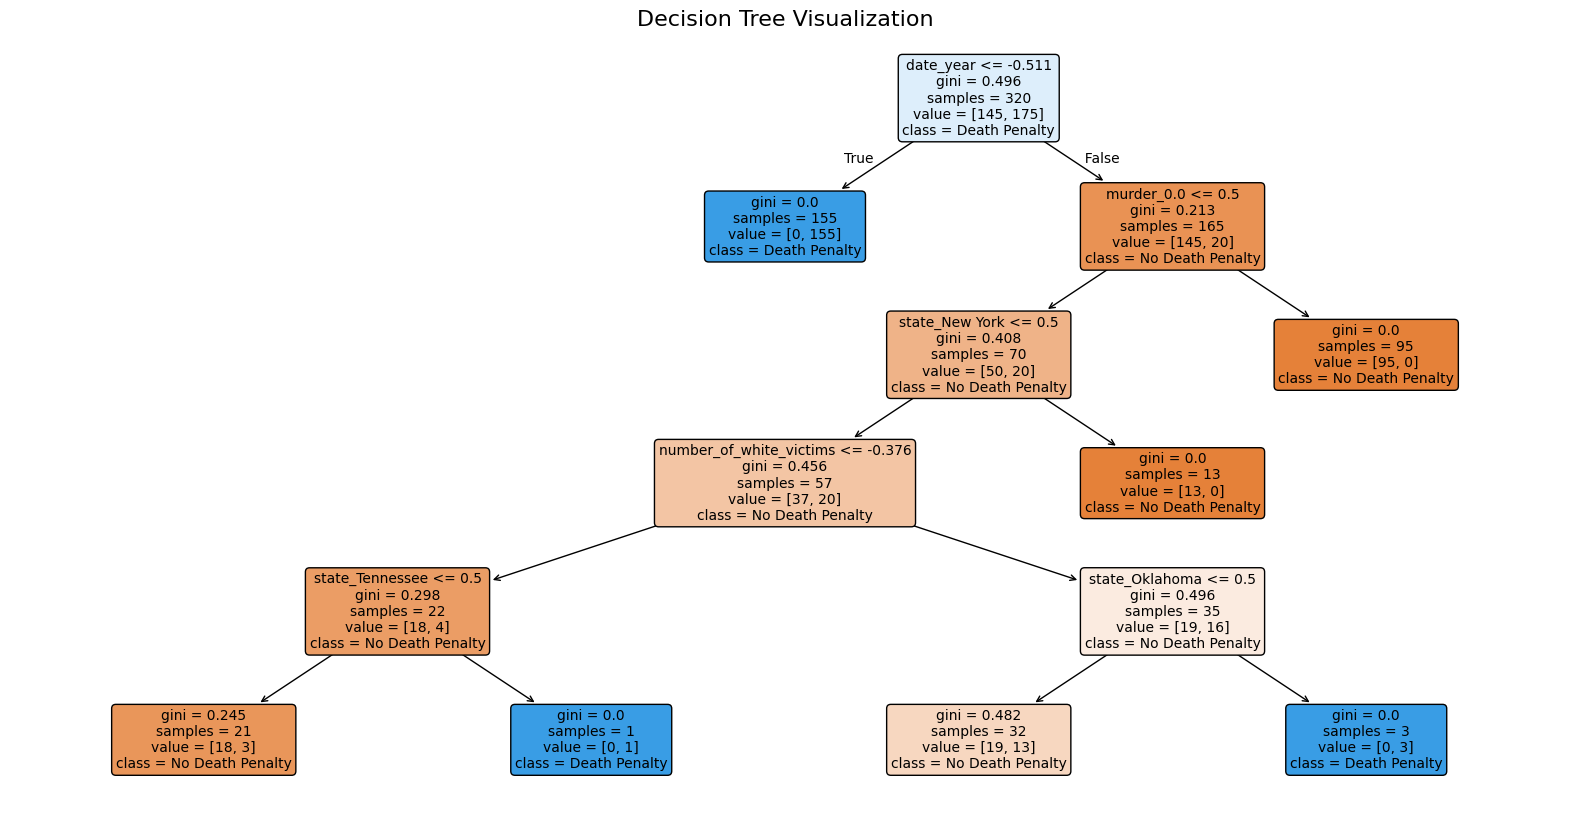

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5) 
dt_model.fit(preprocessor.fit_transform(X_train), y_train)

plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=numeric_features + 
    preprocessor.named_transformers_['cat']
        .named_steps['onehot']
        .get_feature_names_out(categorical_features).tolist(),
    class_names=['No Death Penalty', 'Death Penalty'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()

The decision tree visualization highlights how various features contribute to predicting whether a case involves the death penalty. The root node splits based on the date_year feature, showing its significance in separating classes. Subsequent nodes examine features like murder, state_New York, and number_of_white_victims, reflecting their influence on classification. The tree structure reveals patterns in the data, such as certain states and victim demographics being associated with specific outcomes. The Gini score in the decision tree represents the level of impurity or mixedness at each node. A Gini score of 0 means the node is perfectly pure, meaning all samples belong to one class (e.g., all are "Death Penalty" cases or all are "No Death Penalty" cases). A higher Gini score (closer to 0.5) indicates more mixed samples at that node. As the tree splits based on features, the Gini score decreases, which means the nodes become purer, helping the model make more accurate classifications.

## Cross Validation

This code performs cross-validation to evaluate the Random Forest and Decision Tree models by splitting the dataset into multiple folds, ensuring fair performance assessment. It computes accuracy scores for each fold and calculates the mean accuracy, providing a more robust measure of model performance compared to a single train-test split.

In [46]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Define StratifiedKFold for consistent splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_cv_scores = cross_val_score(rf_clf, X, y, cv=cv, scoring='accuracy')
print("Random Forest Cross-Validation Accuracy Scores:", rf_cv_scores)
print("Random Forest Mean Accuracy:", rf_cv_scores.mean())

dt_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=5))
])

dt_cv_scores = cross_val_score(dt_clf, X, y, cv=cv, scoring='accuracy')
print("\nDecision Tree Cross-Validation Accuracy Scores:", dt_cv_scores)
print("Decision Tree Mean Accuracy:", dt_cv_scores.mean())


Random Forest Cross-Validation Accuracy Scores: [0.95   0.95   0.875  0.95   0.9625]
Random Forest Mean Accuracy: 0.9375

Decision Tree Cross-Validation Accuracy Scores: [0.9375 0.9375 0.8875 0.9625 0.9125]
Decision Tree Mean Accuracy: 0.9275


The cross-validation results show that the Random Forest model achieved an average accuracy of 93.75%, while the Decision Tree model achieved a slightly lower average accuracy of 92.75%. These scores highlight that both models perform well, with Random Forest slightly outperforming Decision Tree in terms of overall accuracy.

## Petitions

As the final analysis of this project, I will explore petition data that was extracted earlier in the project. This dataset provides a snapshot of current-day petitions related to the death penalty, offering insight into public sentiment, advocacy efforts, and areas of focus within ongoing campaigns.

In [40]:
df_petitions = pd.read_csv("../../data/processed-data/cleaned_petitions_descriptions.csv")

This code processes a dataset of petitions, detecting the primary emotion expressed in each petition's description and the model's confidence in that classification. The results are added as new columns for analysis.

In [41]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "SamLowe/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

emotion_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    padding=True,          
    truncation=True,      
    max_length=512         
)

def detect_emotion(text):
    if isinstance(text, str) and len(text.strip()) > 0:
        try:
            result = emotion_pipeline(text)
            return result[0]['label'], result[0]['score']
        except IndexError:
            return None, None
    return None, None

df_petitions[['emotion', 'confidence']] = df_petitions['cleaned_description'].apply(
    detect_emotion
).apply(pd.Series)

print(df_petitions.head())

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


                                name  \
0           carey-grayson-in-alabama   
1   christopher-collings-in-missouri   
2  marion-bowman-in-south-carolina-2   
3                corcoran-in-indiana   
4        kevin-underwood-in-oklahoma   

                                         description  \
0  An execution date has been set for Alabama dea...   
1  Christopher Collings  is scheduled for executi...   
2  Marion Bowman is scheduled for execution in So...   
3  An execution date has been set for Indiana dea...   
4  Oklahoma had plans to execute Kevin Underwood ...   

                                 cleaned_description  emotion  confidence  
0  An execution date has been set for Alabama dea...  neutral    0.858828  
1  Christopher Collings is scheduled for executio...  neutral    0.446952  
2  Marion Bowman is scheduled for execution in So...  neutral    0.915289  
3  An execution date has been set for Indiana dea...  neutral    0.855573  
4  Oklahoma had plans to execute Kevin Und

In [42]:
df_petitions

,name,description,cleaned_description,emotion,confidence
0,carey-grayson-in-alabama,An execution date has been set for Alabama dea...,An execution date has been set for Alabama dea...,neutral,0.858828
1,christopher-collings-in-missouri,Christopher Collings is scheduled for executi...,Christopher Collings is scheduled for executio...,neutral,0.446952
2,marion-bowman-in-south-carolina-2,Marion Bowman is scheduled for execution in So...,Marion Bowman is scheduled for execution in So...,neutral,0.915289
3,corcoran-in-indiana,An execution date has been set for Indiana dea...,An execution date has been set for Indiana dea...,neutral,0.855573
4,kevin-underwood-in-oklahoma,Oklahoma had plans to execute Kevin Underwood ...,Oklahoma had plans to execute Kevin Underwood ...,neutral,0.716961
5,steven-nelson-in-texas,"In 2012, Steven Nelson was convicted of the ca...",In Steven Nelson was convicted of the capital ...,disappointment,0.282522
6,willie-manning-in-mississippi,Willie Manning faces an imminent and short-not...,Willie Manning faces an imminent and shortnoti...,neutral,0.717407
7,ralph-menzies-in-utah,The state of Utah filed a court request on Jan...,The state of Utah filed a court request on Jan...,neutral,0.924229
8,robert-simon-in-mississippi,Robert Simon faces an imminent and short-notic...,Robert Simon faces an imminent and shortnotice...,neutral,0.902536
9,tremane-wood-in-oklahoma,Tremane Wood is on death row in Oklahoma for t...,Tremane Wood is on death row in Oklahoma for t...,neutral,0.846857


Most of the detected emotions in the petition descriptions are neutral, which might indicate a lack of emotional appeal, a key factor for petitions to effectively engage their audience and drive action. There was one petition expressing disappointment and another showing gratitude, possibly acknowledging support or progress in the cause. This highlights the opportunity to craft more compelling, emotionally charged descriptions to better resonate with supporters.

# Summary

This analysis demonstrated the effectiveness of Random Forest and Decision Tree models in predicting death penalty cases, with Random Forest achieving a slightly higher mean accuracy. Key predictors such as the case year and victim demographics were identified as significant features. The sentiment analysis of petitions revealed a predominantly neutral tone, suggesting opportunities to craft more emotionally engaging descriptions to mobilize public support. These findings underscore the potential of data-driven approaches in understanding and addressing issues surrounding the death penalty.

# Future Work

![](../../assets/future.png){width=100px align="left"}

Future work for this analysis involves compiling a larger dataset with additional features to enhance predictive accuracy and insights. Expanding the dataset to include more types of crimes beyond murder, rape, and "other" will allow for a more comprehensive analysis of factors influencing death penalty outcomes. Additionally, incorporating geographical information, such as the county where the crime occurred, could significantly improve predictions, as previous findings highlighted the county's substantial impact on death penalty decisions. This analysis serves as a foundational starting point, with the potential for further refinement and expansion.

[Download all_sup.csv](../../data/raw-data/all_sup.csv)

[Download death_sup.csv](../../data/raw-data/death_sup.csv)